In [2]:
from fastcore.test import test_eq
from fastcore.basics import first
from fastai.data.external import untar_data, URLs
from fastai.tabular.data import TabularDataLoaders
from fastai.tabular.core import Categorify, FillMissing
from fastai.data.transforms import Normalize
import pandas as pd

/Users/radicho/opt/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from tsai.all import *

In [5]:
gMLP

tsai.models.gMLP.gMLP

In [6]:
GatedTabTransformer

tsai.models.GatedTabTransformer.GatedTabTransformer

# gMLP `tsai` learner demo
Demo showing the gMLPClassification extension of the original gMLP ***(Liu H., et al., 2021)*** proposed in ***(Cholakov R. & Kolev T., 2022)***.

In [7]:
X, y, splits = get_classification_data('ECG200', split_data=False)
batch_tfms = TSStandardize()

epoch,train_loss,valid_loss,accuracy,time
0,0.645044,0.664603,0.640000,00:00
1,0.637332,0.671460,0.640000,00:00
2,0.623799,0.704115,0.640000,00:00
3,0.631407,0.692243,0.640000,00:00
4,0.636447,0.659587,0.640000,00:00
5,0.636221,0.662528,0.640000,00:00
6,0.636813,0.654343,0.640000,00:00
7,0.627066,0.760537,0.640000,00:00
8,0.632240,0.714936,0.640000,00:00
9,0.628835,0.640843,0.640000,00:00


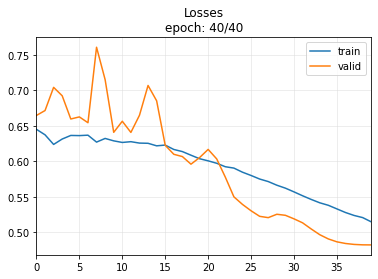

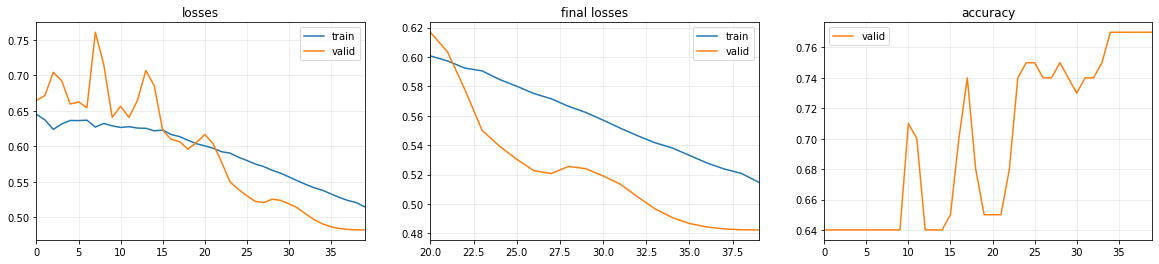

In [9]:
clf = TSClassifier(X, y, splits=splits, arch=gMLP, arch_config={"patch_size": 4}, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph())
clf.fit_one_cycle(40, 3e-4)

# GatedTabTransformer `PyTorch` demo
Demo showing the proposed GatedTabTransformer ***(Cholakov R. & Kolev T., 2022)*** as a part of a standard PyTorch training process (imported using `tsai`).

In [10]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,36,Private,297449,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Male,14084,0,40,United-States,>=50k
32557,23,?,123983,Bachelors,13.0,Never-married,?,Own-child,Other,Male,0,0,40,United-States,<50k
32558,53,Private,157069,Assoc-acdm,12.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>=50k
32559,32,Local-gov,217296,HS-grad,9.0,Married-civ-spouse,Transport-moving,Wife,White,Female,4064,0,22,United-States,<50k


In [11]:
dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

In [13]:
model = GatedTabTransformer(dls.classes, dls.cont_names, dls.c)

In [14]:
criterion = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [15]:
for epoch in range(1):
    running_loss = 0.0

    for i, batch in enumerate(dls.train):

        x_cat, x_cont, yb = batch
        
        optimizer.zero_grad()
        out = model(x_cat, x_cont)
        loss = criterion(out, yb.squeeze().to(dtype=torch.long))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 20 == 19:
            print('[%d, %6d] loss: %.6f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0
    
    scheduler.step()

[1,     20] loss: 0.645202
[1,     40] loss: 0.506764
[1,     60] loss: 0.521815
[1,     80] loss: 0.504056
[1,    100] loss: 0.453701
[1,    120] loss: 0.426893
[1,    140] loss: 0.373287
[1,    160] loss: 0.406229
[1,    180] loss: 0.392246
[1,    200] loss: 0.372844
[1,    220] loss: 0.383490
[1,    240] loss: 0.359620
[1,    260] loss: 0.385487
[1,    280] loss: 0.341413
[1,    300] loss: 0.371687
[1,    320] loss: 0.379152
[1,    340] loss: 0.393179
[1,    360] loss: 0.359096
[1,    380] loss: 0.367902
[1,    400] loss: 0.376438


# GatedTabTransformer `tsai` learner demo

epoch,train_loss,valid_loss,time
0,0.360330,0.369206,01:35


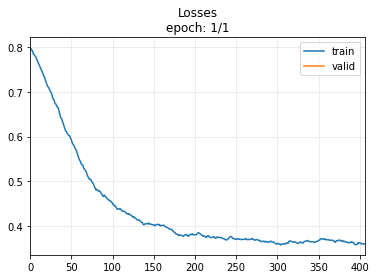

not enough values to plot a chart


In [16]:
model = GatedTabTransformer(dls.classes, dls.cont_names, dls.c)
learn = Learner(dls, model, cbs=ShowGraph())
learn.fit_one_cycle(1)